In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

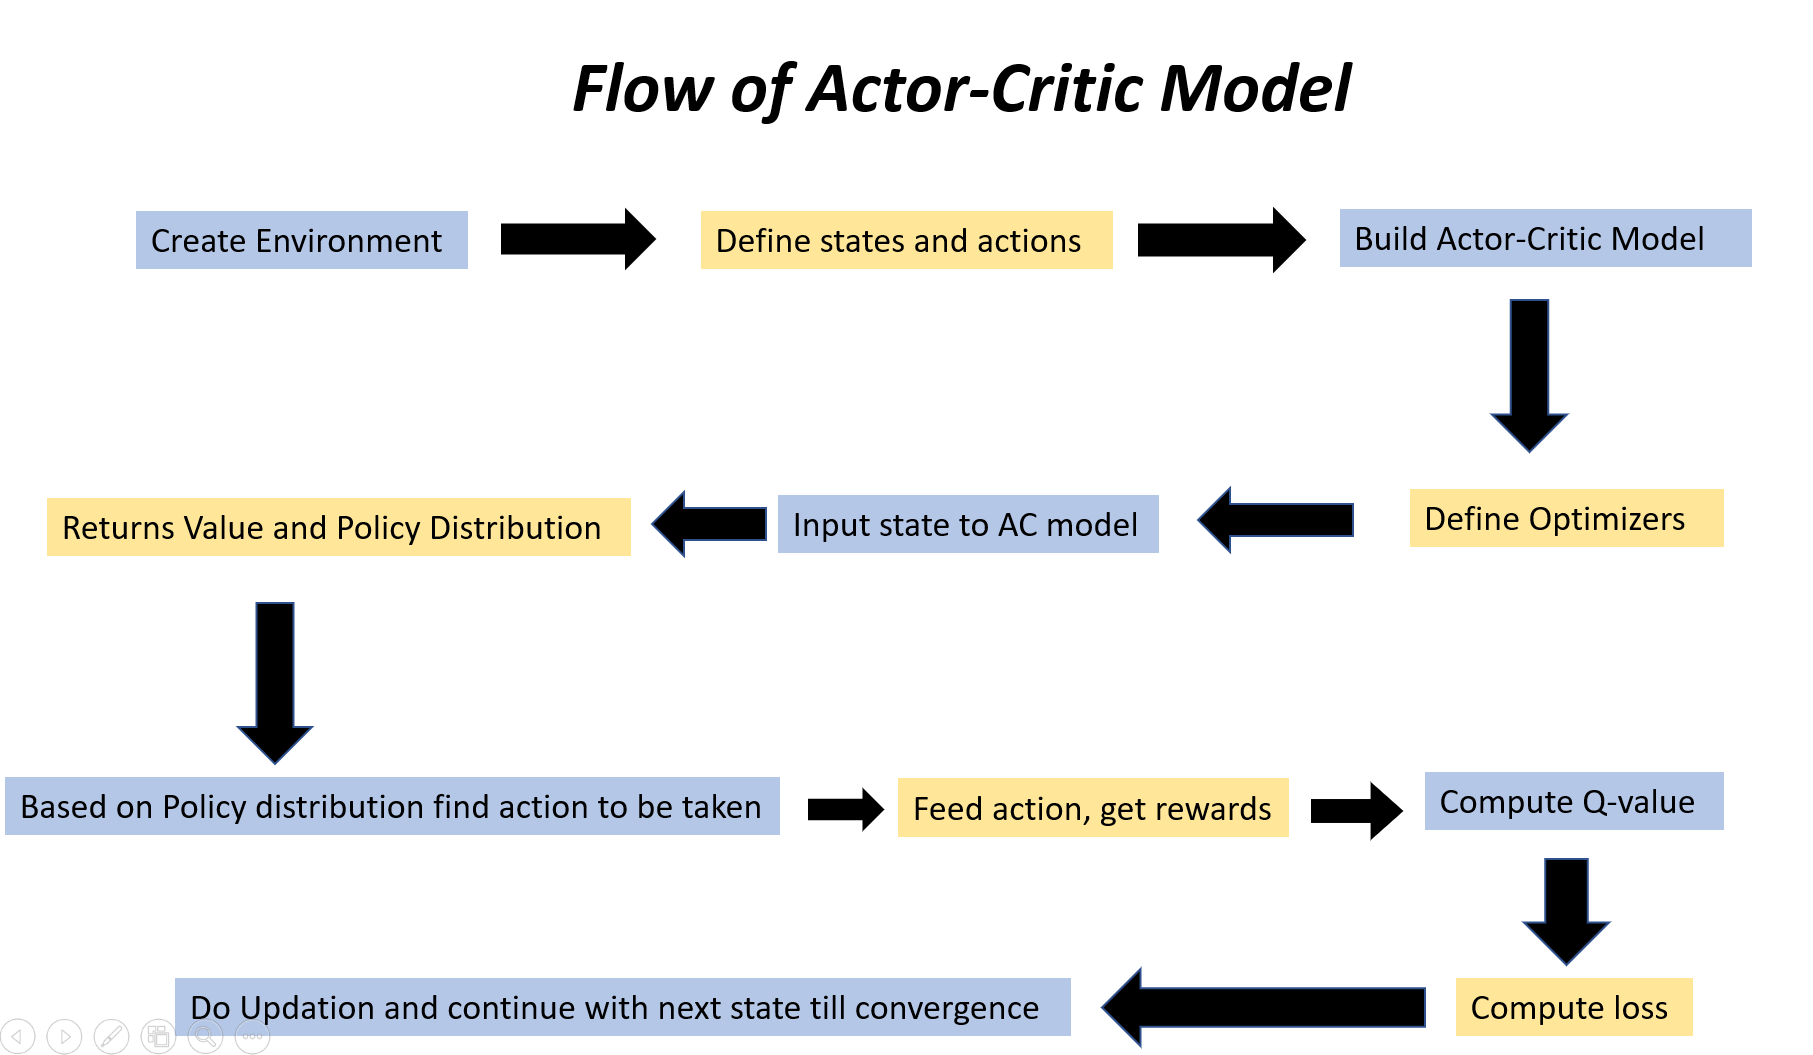

**About Actor-Critic in Brief**

- Actor-Critic arises from the Reinforce Algorithm
- In Reinforce algorithm, we take random samples and train the model
- This led to randonmness in the distribution of probablity values and high Variance
- Hence, researchers came up with a solution of creating baselines with Reinforce formula
- On such baseline is Actor-Critic which reduces high variance
- Critic: Estimates the value function
  Actor: updates the policy distribution in the direction suggested by the Critic 
- Always while building a deep network model, the policy will be a function approximator which is nothing but a neural network through which weights are calculated and updated
- Here also, the Q-value is learned by parameterizing the Q function with a neural network

- In Reinforcement Learning, when building a deep network model, tensors are only used for implementation.
- There are modules available for Deep network models like Neural Network.
- Similarly for optimizing the parameters also inbuilt modlues are available.

I have used Cartpole example to understand and implement a basic Actor-Critic model

In [2]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque

In [3]:
# hyperparameters
# No of neurons in the hidden state
hidden_size = 256
learning_rate = 0.0003

# Constants
gamma = 0.99
num_steps = 300
max_episodes = 3000

In Actor-Critic model, 
- Lags are used which is considered as history
- That is, if some history available, our model could learn better

In [4]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate):
        super(ActorCritic, self).__init__()

        self.num_actions = num_actions
        self.critic_layer = nn.Linear(num_inputs, hidden_size)
        self.critic_lag = nn.Linear(hidden_size, 1)

        self.actor_layer = nn.Linear(num_inputs, hidden_size)
        self.actor_lag = nn.Linear(hidden_size, num_actions)
    
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.critic_layer(state))
        value = self.critic_lag(value)
        
        policy_dist = F.relu(self.actor_layer(state))
        policy_dist = F.softmax(self.actor_lag(policy_dist), dim=1)

        return value, policy_dist

In [5]:
def a2c(env):
    num_of_states = env.observation_space.shape[0]
    num_of_actions = env.action_space.n
    
    actor_critic = ActorCritic(num_of_states, num_of_actions, hidden_size, learning_rate)
    ac_optimizer = optim.Adam(actor_critic.parameters())

    all_lengths = []
    average_lengths = []
    all_rewards = []
    # For improving exploration entropy term is added while calculating loss
    entropy_term = 0

    for episode in range(max_episodes):
        log_probs = []
        values = []
        rewards = []

        state = env.reset()
        
        for steps in range(num_steps):
            value, policy_dist = actor_critic.forward(state)
            # Conversions of its shape are done to get appropriate results that are given out by the model
            value = value.detach().numpy()[0,0]
            dist = policy_dist.detach().numpy() 

            action = np.random.choice(num_of_actions, p=np.squeeze(dist))
            log_prob = torch.log(policy_dist.squeeze(0)[action])
            entropy = -np.sum(np.mean(dist) * np.log(dist))
            new_state, reward, done, _ = env.step(action)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            entropy_term += entropy
            state = new_state
            
            if done or steps == num_steps-1:
                Qval, _ = actor_critic.forward(new_state)
                Qval = Qval.detach().numpy()[0,0]
                all_rewards.append(np.sum(rewards))
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-10:]))
                # For every 100th episode we see the Cumulative Reward
                if episode % 100 == 0:                    
                    print("Episode:",episode,"Reward:",np.sum(rewards))
                break
        
        # compute Q values
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + gamma * Qval
            Qvals[t] = Qval
  
        # Converting values and Q-values to float as probabilities will be in float
        values = torch.FloatTensor(values)
        Qvals = torch.FloatTensor(Qvals)
        log_probs = torch.stack(log_probs)
        
        # Advantage actor-critic
        advantage = Qvals - values
        
        # Finding loss
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

        # Resetting the optimizer for next iteration
        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()
        
    return all_rewards,all_lengths,average_lengths

In [6]:
env = gym.make("CartPole-v0")
all_rewards, all_lengths, average_lengths = a2c(env)

Episode: 0 Reward: 17.0
Episode: 100 Reward: 15.0
Episode: 200 Reward: 31.0
Episode: 300 Reward: 152.0
Episode: 400 Reward: 112.0
Episode: 500 Reward: 122.0
Episode: 600 Reward: 200.0
Episode: 700 Reward: 154.0
Episode: 800 Reward: 139.0
Episode: 900 Reward: 200.0
Episode: 1000 Reward: 200.0
Episode: 1100 Reward: 200.0
Episode: 1200 Reward: 157.0
Episode: 1300 Reward: 200.0
Episode: 1400 Reward: 200.0
Episode: 1500 Reward: 200.0
Episode: 1600 Reward: 200.0
Episode: 1700 Reward: 111.0
Episode: 1800 Reward: 163.0
Episode: 1900 Reward: 200.0
Episode: 2000 Reward: 200.0
Episode: 2100 Reward: 200.0
Episode: 2200 Reward: 200.0
Episode: 2300 Reward: 200.0
Episode: 2400 Reward: 200.0
Episode: 2500 Reward: 200.0
Episode: 2600 Reward: 200.0
Episode: 2700 Reward: 26.0
Episode: 2800 Reward: 31.0
Episode: 2900 Reward: 105.0


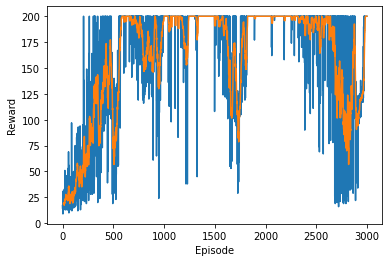

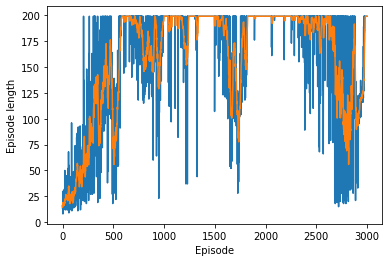

In [7]:
# Plot results
smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
smoothed_rewards = [elem for elem in smoothed_rewards]
plt.plot(all_rewards)
plt.plot(smoothed_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

plt.plot(all_lengths)
plt.plot(average_lengths)
plt.xlabel('Episode')
plt.ylabel('Episode length')

plt.show()

From the graph we say that, our model has learnt steadily